# Cache Dataset Tutorial and Speed Test

This tutorial shows how to accelerate PyTorch medical DL program based on MONAI CacheDataset.  
It's modified from the Spleen 3D segmentation tutorial notebook.

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import glob
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from monai.data import Dataset, CacheDataset
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, RandCropByPosNegLabeld, \
    RandAffined, Spacingd, Orientationd, ToTensord
from monai.data import list_data_collate, sliding_window_inference
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import compute_meandice

## Set MSD Spleen dataset path

In [2]:
data_root = '/workspace/data/medical/Task09_Spleen'
train_images = glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz'))
train_labels = glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz'))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation
  
Deterministic transforms:  
- LoadNiftid  
- AddChanneld  
- Spacingd  
- Orientationd  
- ScaleIntensityRanged  
  
Non-deterministic transforms:  
- RandCropByPosNegLabeld  
- ToTensord

The results of all the deterministic transforms will be cached to acclerate training.

In [3]:
train_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=(3, 0)),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', size=(96, 96, 96), pos=1,
                           neg=1, num_samples=4, image_key='image', image_threshold=0),
    ToTensord(keys=['image', 'label'])
])
val_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=(3, 0)),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    ToTensord(keys=['image', 'label'])
])

## Define deterministic training for reproducibility

In [4]:
def set_deterministic():
    train_transforms.set_random_state(seed=0)
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Define a typical PyTorch training process

In [5]:
def train_process(train_ds, val_ds):
    # use batch_size=2 to load images and use RandCropByPosNegLabeld
    # to generate 2 x 4 images for network training
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=list_data_collate)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
    device = torch.device("cuda:0")
    model = UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceLoss(to_onehot_y=True, do_softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)

    epoch_num = 20
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    epoch_times = list()
    total_start = time.time()
    for epoch in range(epoch_num):
        epoch_start = time.time()
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch + 1, epoch_num))
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d, train_loss: %0.4f, step time: %0.4f" %
                  (step, len(train_ds) // train_loader.batch_size, loss.item(), time.time() - step_start))
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print("epoch %d average loss: %0.4f" % (epoch + 1, epoch_loss))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                metric_sum = 0.
                metric_count = 0
                for val_data in val_loader:
                    val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                             to_onehot_y=True, mutually_exclusive=True)
                    metric_count += len(value)
                    metric_sum += value.sum().item()
                metric = metric_sum / metric_count
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), 'best_metric_model.pth')
                    print('saved new best metric model')
                print('current epoch %d current mean dice: %0.4f best mean dice: %0.4f at epoch %d'
                      % (epoch + 1, metric, best_metric, best_metric_epoch))
        print('time consuming of epoch %d is: %0.4f' % (epoch + 1, time.time() - epoch_start))
        epoch_times.append(time.time() - epoch_start)
    print('train completed, best_metric: %0.4f  at epoch: %d, total time: %0.4f' %
          (best_metric, best_metric_epoch, time.time() - total_start))
    return epoch_num, time.time() - total_start, epoch_loss_values, metric_values, epoch_times

## Define normal Dataset for training and validation

In [6]:
set_deterministic()
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

## Train with normal Dataset

In [ ]:
epoch_num, total_time, epoch_loss_values, metric_values, epoch_times = train_process(train_ds, val_ds)
print('Total training time of %d epochs with normal Dataset: %0.4f' % (epoch_num, total_time))

## Define Cache Dataset for training and validation

In [8]:
set_deterministic()
cache_init_start = time.time()
cache_train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
cache_val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
cache_init_time = time.time() - cache_init_start

Loading data to cache and executing transforms...
32/32 [==============================]  
Loading data to cache and executing transforms...
9/9 [==============================]  


## Train with Cache Dataset

In [ ]:
epoch_num, cache_total_time, cache_epoch_loss_values, cache_metric_values, cache_epoch_times = \
    train_process(cache_train_ds, cache_val_ds)
print('Total training time of %d epochs with CacheDataset: %0.4f' % (epoch_num, cache_total_time))

## Plot training loss and validation metrics

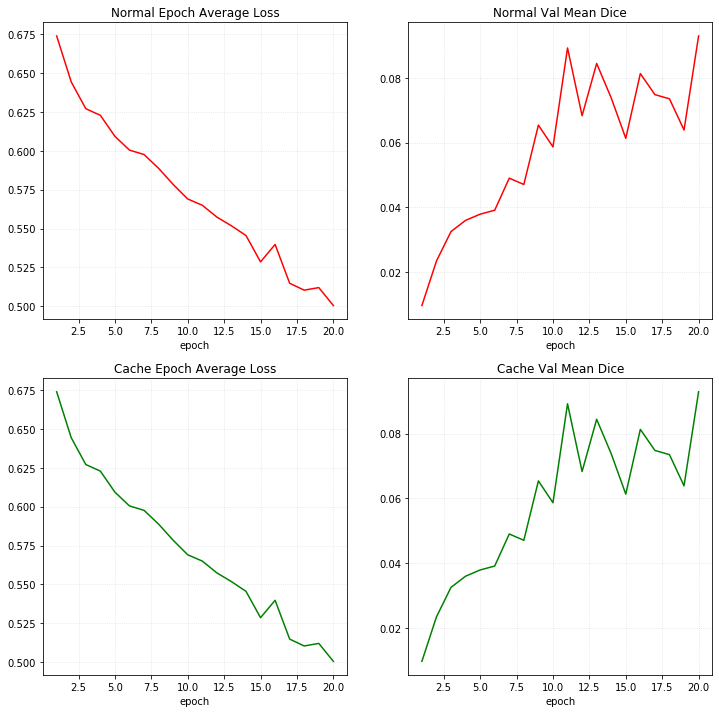

In [13]:
plt.figure('train', (12, 12))
plt.subplot(2, 2, 1)
plt.title("Normal Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(2, 2, 2)
plt.title("Normal Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(2, 2, 3)
plt.title("Cache Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')

plt.subplot(2, 2, 4)
plt.title("Cache Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')
plt.show()

## Plot total time and epoch times

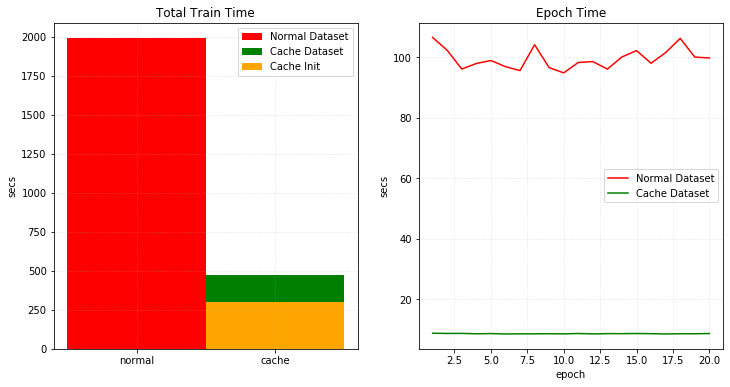

In [11]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Total Train Time")
plt.bar('normal', total_time, 1, label='Normal Dataset', color='red')
plt.bar('cache', cache_init_time + cache_total_time, 1, label='Cache Dataset', color='green')
plt.bar('cache', cache_init_time, 1, label='Cache Init', color='orange')
plt.ylabel('secs')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel('epoch')
plt.ylabel('secs')
plt.plot(x, epoch_times, label='Normal Dataset', color='red')
plt.plot(x, cache_epoch_times, label='Cache Dataset', color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc="best")
plt.show()